[CANVA](https://www.canva.com/design/DAGHAJlyFdo/4omLrgDVt1n2d-WG9QlXsA/edit)

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pytensor.tensor as tt

# Importação da base de dados

In [5]:
# Carregamento dos dados a partir de um arquivo CSV localizado no Google Drive.
original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PI5/staging/porto_ts.csv')

In [6]:
original

,ano,mes,porto,graos,outras,sugar
0,2005,1,5027941,412400,1780376,581383
1,2005,2,5316605,707274,1821686,878016
2,2005,3,5899912,1221079,1917759,610140
3,2005,4,5850639,1301598,1976311,764285
4,2005,5,6826372,1575474,2122232,1007705
...,...,...,...,...,...,...
211,2022,8,14626790,4122517,3188229,2455597
212,2022,9,13628567,3743920,3258989,2079487
213,2022,10,14435751,4185655,3198681,2249483
214,2022,11,12194409,3459541,2558110,2199680


### Alguns ajustes para o projeto atual

In [7]:
# remoção de colunas desnecessárias
original.drop(['graos','outras','sugar'], axis=1, inplace=True)

In [8]:
original

,ano,mes,porto
0,2005,1,5027941
1,2005,2,5316605
2,2005,3,5899912
3,2005,4,5850639
4,2005,5,6826372
...,...,...,...
211,2022,8,14626790
212,2022,9,13628567
213,2022,10,14435751
214,2022,11,12194409


In [9]:
# Conversão das colunas 'ano' e 'mes' para um índice datetime.
original['data'] = pd.to_datetime(original['ano'].astype(str) + '-' + original['mes'].astype(str), format='%Y-%m')
original['lastDay'] = original['data'] + pd.offsets.MonthBegin(0)   # set a data no início do mês
#original['lastDay'] = original['data'] + pd.offsets.MonthEnd(0)    # set a data no final do mês

original['data'] = original['lastDay'].dt.strftime("%Y-%m-%d")
original.drop(['lastDay'], axis=1, inplace=True)

print(original)

      ano  mes     porto        data
0    2005    1   5027941  2005-01-01
1    2005    2   5316605  2005-02-01
2    2005    3   5899912  2005-03-01
3    2005    4   5850639  2005-04-01
4    2005    5   6826372  2005-05-01
..    ...  ...       ...         ...
211  2022    8  14626790  2022-08-01
212  2022    9  13628567  2022-09-01
213  2022   10  14435751  2022-10-01
214  2022   11  12194409  2022-11-01
215  2022   12  12096270  2022-12-01

[216 rows x 4 columns]


In [10]:
data_orig = original.data[:len(original)]    # verificar
data_orig

0      2005-01-01
1      2005-02-01
2      2005-03-01
3      2005-04-01
4      2005-05-01
          ...    
211    2022-08-01
212    2022-09-01
213    2022-10-01
214    2022-11-01
215    2022-12-01
Name: data, Length: 216, dtype: object

## Normalização da data


In [11]:
min_month = original.index.min()
max_month = original.index.max()
print(min_month, max_month)
data_std = (original.index - min_month)/(max_month-min_month)
original['data_std'] = data_std

0 215


## Normalização da movimentação

In [12]:
maximo_mov = original.porto.max()
minimo_mov = original.porto.min()
print(maximo_mov, minimo_mov)
mov_std = (original.porto - minimo_mov) / (maximo_mov - minimo_mov)
original['porto_std'] = mov_std
original

15165869 4588410


,ano,mes,porto,data,data_std,porto_std
0,2005,1,5027941,2005-01-01,0.000000,0.041554
1,2005,2,5316605,2005-02-01,0.004651,0.068844
2,2005,3,5899912,2005-03-01,0.009302,0.123990
3,2005,4,5850639,2005-04-01,0.013953,0.119332
4,2005,5,6826372,2005-05-01,0.018605,0.211578
...,...,...,...,...,...,...
211,2022,8,14626790,2022-08-01,0.981395,0.949035
212,2022,9,13628567,2022-09-01,0.986047,0.854662
213,2022,10,14435751,2022-10-01,0.990698,0.930974
214,2022,11,12194409,2022-11-01,0.995349,0.719076


## Gerando dataframe apenas com dados necessários

In [13]:
original_std = original[['data_std', 'porto_std']]
original_std.index = original_std.data_std
original_std.drop(['data_std'], axis=1,inplace=True)
original_std

<ipython-input-13-66111c678ec3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_std.drop(['data_std'], axis=1,inplace=True)


,porto_std
data_std,
0.000000,0.041554
0.004651,0.068844
0.009302,0.123990
0.013953,0.119332
0.018605,0.211578
...,...
0.981395,0.949035
0.986047,0.854662
0.990698,0.930974


# Divisão dos dados em Treino / Teste  aproximadamente 80%

In [14]:
# Definindo os dados para treinamento
x = original_std.index.values.T
y = original_std.porto_std.values.T

# percentual para treinamento
perc = 0.8                          # o mais próximo possível
periodo = int(len(x) * perc // 12)       # período em anos
n = periodo * 12
treino_split = n-1       # anos para treino /total

# Exibindo a divisão de dados para treino
print(f'{n} meses\n{n/12} anos\n{treino_split/216*100:.2f} %')

168 meses
14.0 anos
77.31 %


In [15]:
# Final do período de treino
original.iloc[treino_split]

ano                2018
mes                  12
porto          10863015
data         2018-12-01
data_std       0.776744
porto_std      0.593205
Name: 167, dtype: object

In [16]:
# separação treino/teste
x_treino = x[ :treino_split+1]
x_teste  = x[treino_split+1: ]

y_treino = y[:treino_split+1]
y_teste  = y[treino_split+1:]


In [17]:
print(len(x_treino), len(y_treino), len(x_teste), len(y_teste))

168 168 48 48


In [18]:
#x_treino
#x_teste
#y_treino
y_teste

array([0.41544099, 0.51814968, 0.64249835, 0.57047983, 0.6055651 ,
       0.66068353, 0.77338206, 0.70899599, 0.65999821, 0.77529149,
       0.60890163, 0.53158296, 0.35217721, 0.57364165, 0.77605103,
       0.8415212 , 0.80086976, 0.73515047, 0.84843212, 0.86455537,
       0.71691055, 0.74599126, 0.71206553, 0.68780479, 0.43526049,
       0.59929223, 1.        , 0.86706268, 0.89786309, 0.82046662,
       0.76002526, 0.7069229 , 0.68669252, 0.58038448, 0.62902461,
       0.71229858, 0.57778763, 0.78576679, 0.99933207, 0.87020758,
       0.91222703, 0.90346642, 0.94496306, 0.94903511, 0.85466245,
       0.93097416, 0.7190762 , 0.70979807])

[Text(0.5, 1.0, 'Separação Treino / Teste'),
 Text(0.5, 0, 't'),
 Text(0, 0.5, '')]

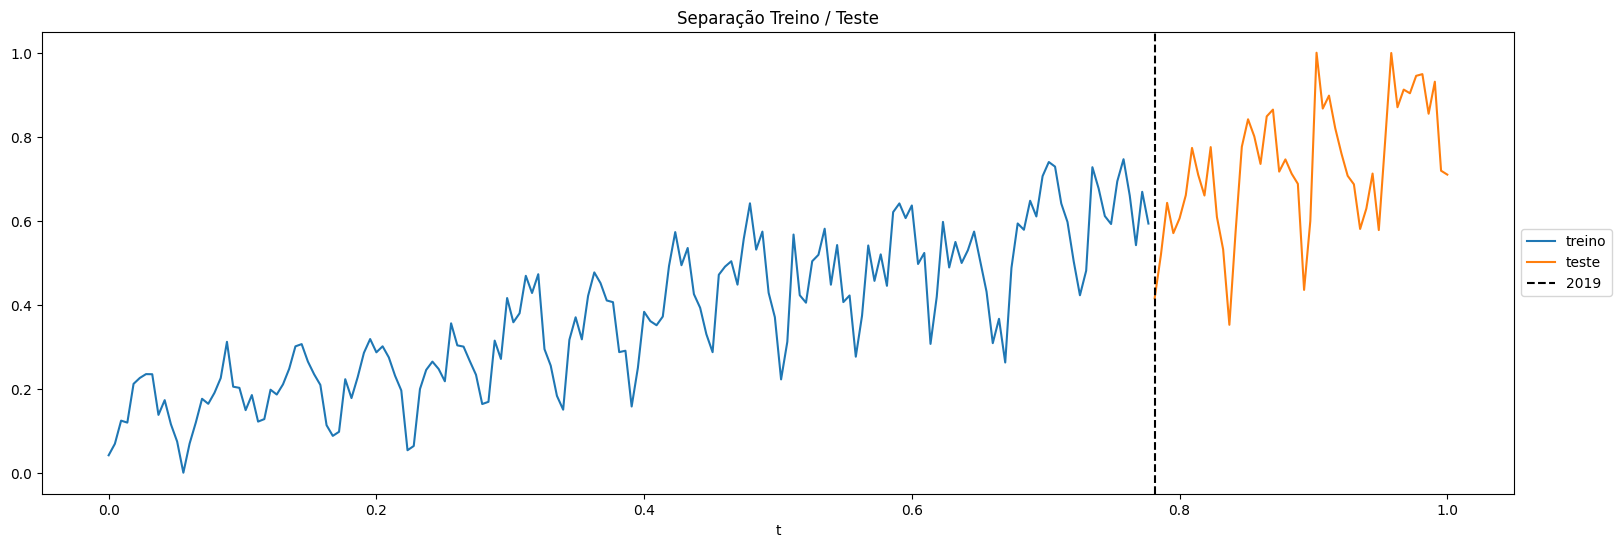

In [19]:
# Plot
fig, ax = plt.subplots(figsize=(19,6))
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), label='treino', ax=ax)
sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), label='teste', ax=ax)
ax.axvline(x=x_teste.flatten()[0], linestyle='--', label='2019', color='black')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Separação Treino / Teste', xlabel='t', ylabel='')

# Modelo Prophet - Meta

In [20]:
with pm.Model() as model:

    l_ratquad = pm.HalfNormal('l_ratquad', sigma=4)
    alpha_ratquad = pm.HalfNormal('alpha_ratquad', sigma=4)
    sigma_ratquad = pm.HalfNormal('sigma_ratquad', sigma=4)

    l_matern32 = pm.HalfNormal('l_matern32', sigma=0.1)
    sigma_matern32 = pm.HalfNormal('sigma_matern32', sigma=0.1)

    cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)
    cov_matern32 = sigma_matern32 * pm.gp.cov.Matern32(1, l_matern32)

    cov = cov_ratquad + cov_matern32

    a = pm.Normal("a",0,1)
    b = pm.Normal("b",0,0.125)
    trend = pm.Deterministic("trend",a + b*x_treino)
    M = pm.gp.mean.Linear([b],a)

    gp = pm.gp.Marginal(mean_func=M, cov_func=cov)
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = gp.marginal_likelihood('y', X=x_treino.reshape(-1,1),y=y_treino, noise=sigma)


/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


## Preditiva a priori

Para ajustar os parâmetros

In [21]:
with model:
  prior = pm.sample_prior_predictive()

In [22]:
prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

<ipython-input-23-650b73390703>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
<ipython-input-23-650b73390703>:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior", num_samples=100)["trend"] * y_treino.max(),


Text(0.5, 1.0, 'Prior trend lines')

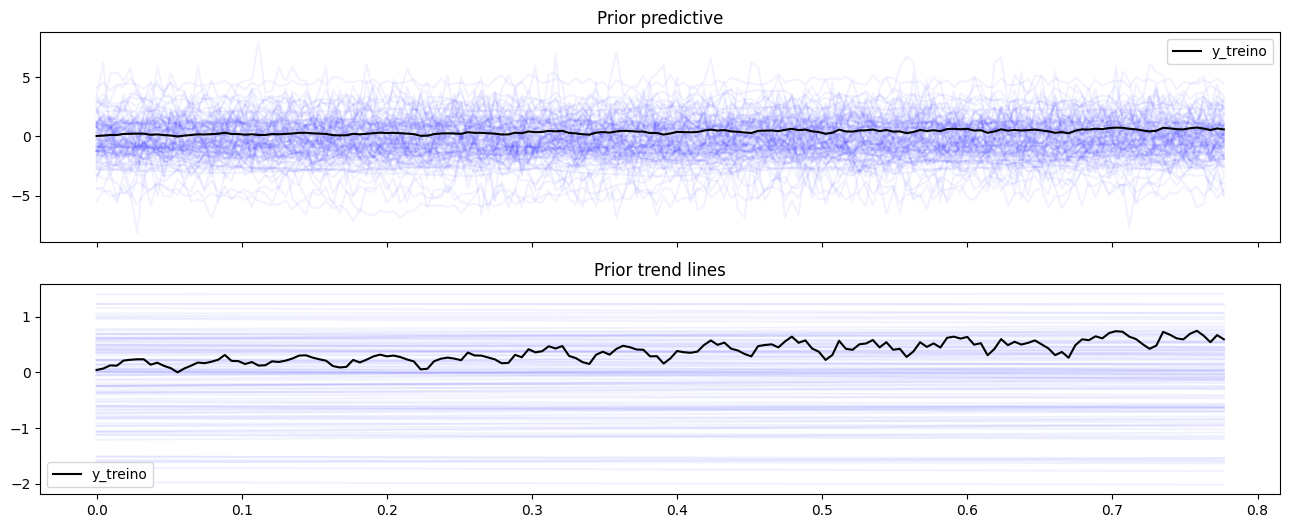

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16,6))
ax[0].plot(
    x_treino,
    az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
    * y_treino.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), color="k", label='y_treino', ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    x_treino,
    az.extract_dataset(prior, group="prior", num_samples=100)["trend"] * y_treino.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), color="k",label='y_treino', ax=ax[1])
ax[1].set_title("Prior trend lines")

In [24]:
with model:
  trace_aprox = pm.fit(20000)
  trace = trace_aprox.sample()

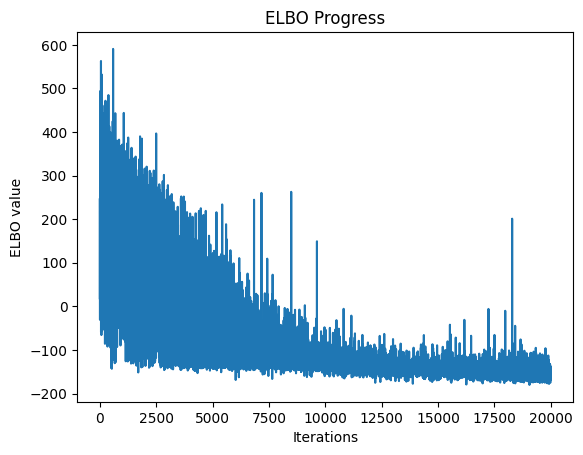

In [25]:
# Não usado
plt.plot(trace_aprox.hist)
plt.title('ELBO Progress')
plt.xlabel('Iterations')
plt.ylabel('ELBO value')
plt.show()

In [26]:
pm.summary(trace)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.104,0.865,-1.558,1.639,0.037,0.027,544.0,514.0,NaN
b,0.057,0.129,-0.192,0.292,0.006,0.005,404.0,555.0,NaN
l_ratquad,4.147,5.206,0.166,10.306,0.229,0.162,534.0,513.0,NaN
alpha_ratquad,3.432,2.193,0.847,7.249,0.095,0.067,488.0,513.0,NaN
sigma_ratquad,3.194,2.871,0.261,7.674,0.129,0.091,453.0,301.0,NaN
...,...,...,...,...,...,...,...,...,...
trend[163],0.147,0.866,-1.500,1.745,0.038,0.027,537.0,463.0,NaN
trend[164],0.147,0.866,-1.499,1.746,0.038,0.027,537.0,463.0,NaN
trend[165],0.147,0.866,-1.499,1.746,0.038,0.027,537.0,463.0,NaN
trend[166],0.148,0.866,-1.509,1.736,0.038,0.027,537.0,463.0,NaN


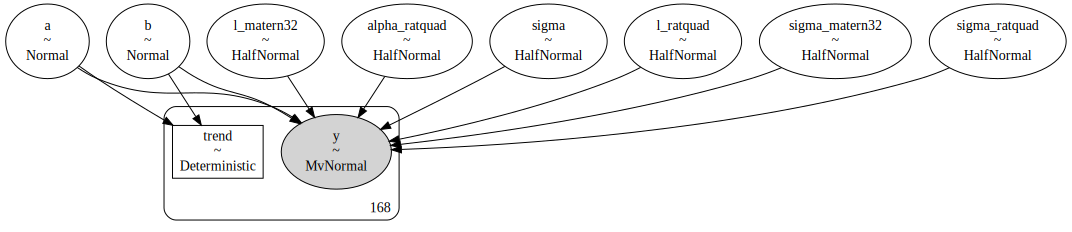

In [27]:
pm.model_to_graphviz(model)

In [28]:
with model:
    x_teste_c = gp.conditional('x_teste', x_teste.reshape(-1,1))
    pred_m = pm.sample_posterior_predictive(trace, var_names=["x_teste"])

In [29]:
pred_m

Inference data with groups:
	> posterior_predictive
	> observed_data

<ipython-input-30-95ff103f091a>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(pred_m, group="posterior_predictive", num_samples=200)["x_teste"],


Text(0.5, 1.0, 'Posterior predictive')

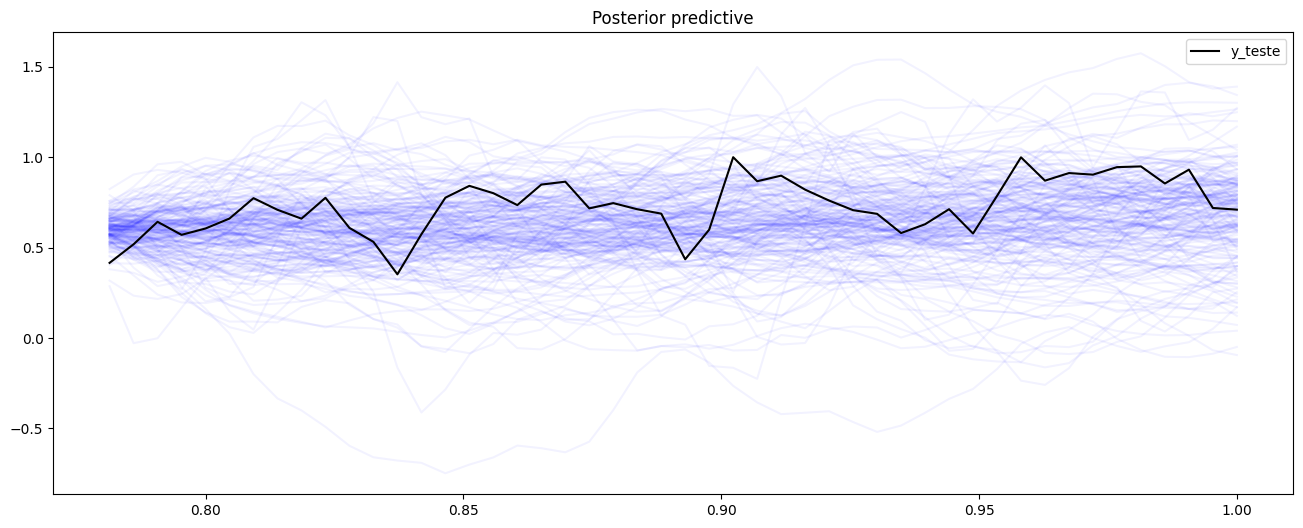

In [30]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(
    x_teste,
    az.extract_dataset(pred_m, group="posterior_predictive", num_samples=200)["x_teste"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), color="k", label='y_teste', ax=ax)
ax.set_title("Posterior predictive")

In [31]:
f_pred_samples = az.extract(pred_m, group="posterior_predictive", var_names=["x_teste"])
f_pred_samples

<xarray.DataArray 'x_teste' (x_teste_dim_2: 48, sample: 500)>
array([[0.69837996, 0.60441896, 0.71341744, ..., 0.59748653, 0.6068119 ,
        0.37423136],
       [0.7030695 , 0.60452284, 0.6252292 , ..., 0.59617805, 0.61946783,
        0.33582003],
       [0.70642481, 0.58831134, 0.60749197, ..., 0.59979438, 0.61106754,
        0.35399132],
       ...,
       [0.5956745 , 0.74081833, 0.59290345, ..., 0.44186598, 0.79079762,
        0.4940692 ],
       [0.58345821, 0.73714051, 0.64596854, ..., 0.48823135, 0.72190981,
        0.49848197],
       [0.57757554, 0.73979781, 0.61742689, ..., 0.54914626, 0.67214003,
        0.48748118]])
Coordinates:
  * x_teste_dim_2  (x_teste_dim_2) int64 0 1 2 3 4 5 6 ... 41 42 43 44 45 46 47
  * sample         (sample) object MultiIndex
  * chain          (sample) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
  * draw           (sample) int64 0 1 2 3 4 5 6 ... 493 494 495 496 497 498 499

<Axes: >

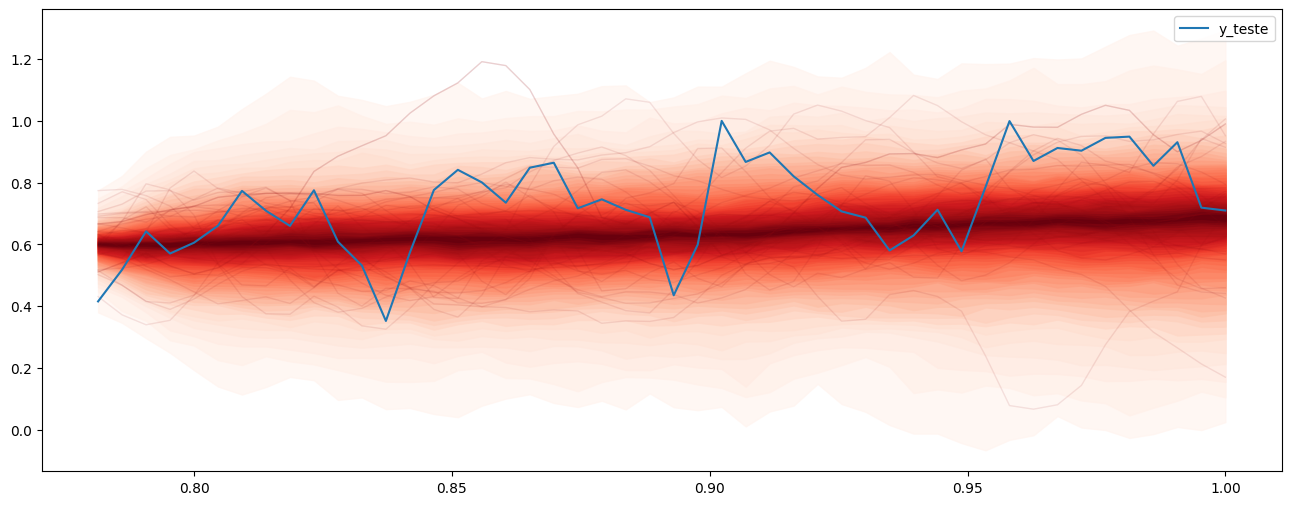

In [32]:
from pymc.gp.util import plot_gp_dist

fig = plt.figure(figsize=(16,6)); ax = fig.gca()

plot_gp_dist(ax, f_pred_samples.T, x_teste);

sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), label='y_teste', ax=ax)

In [33]:
y_pred = pred_m.posterior_predictive["x_teste"].values.mean(axis=1)[0]
print(f"MAE: {abs(y_pred - y_teste).sum()/len(y_teste)}")

MAE: 0.1430564291204707


# Modelo 2

com função de covariância de kernel Rational Quadratic e Matern com nu = 5/2

In [34]:
with pm.Model() as model_2:

    l_ratquad = pm.HalfNormal('l_ratquad', sigma=4)
    alpha_ratquad = pm.HalfNormal('alpha_ratquad', sigma=4)
    sigma_ratquad = pm.HalfNormal('sigma_ratquad', sigma=4)

    l_expquad = pm.HalfNormal('l_expquad', sigma=0.2)
    sigma_expquad = pm.HalfNormal('sigma_expquad', sigma=0.2)
    cov_expquad = sigma_expquad * pm.gp.cov.ExpQuad(1, l_expquad)

    l_matern52 = pm.HalfNormal('l_matern52', sigma=0.5)
    sigma_matern52 = pm.HalfNormal('sigma_matern52', sigma=0.5)

    cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)
    cov_matern52 = sigma_matern52 * pm.gp.cov.Matern52(1, l_matern52)

    cov = cov_ratquad + cov_matern52 + cov_expquad

    gp = pm.gp.Marginal(cov_func=cov)
    sigma = pm.HalfNormal('sigma', sigma=1)
    wn = pm.gp.cov.WhiteNoise(sigma)

    y_obs = gp.marginal_likelihood('y', X=x_treino.reshape(-1,1),y=y_treino, noise=wn)


/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [35]:
with model_2:
  prior = pm.sample_prior_predictive()

<ipython-input-36-d7be83d79ce5>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]


Text(0.5, 1.0, 'Prior predictive')

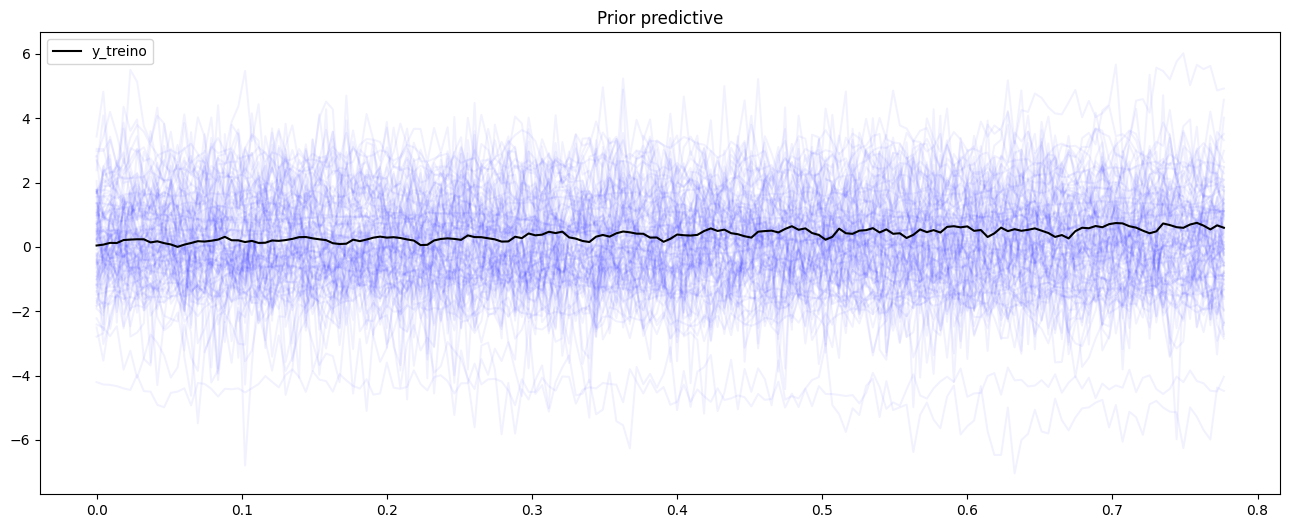

In [36]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(
    x_treino,
    az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
    * y_treino.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), color="k", label='y_treino', ax=ax)
ax.set_title("Prior predictive")

In [37]:
with model_2:
  trace_aprox_2 = pm.fit(20000)
  trace_2 = trace_aprox_2.sample()

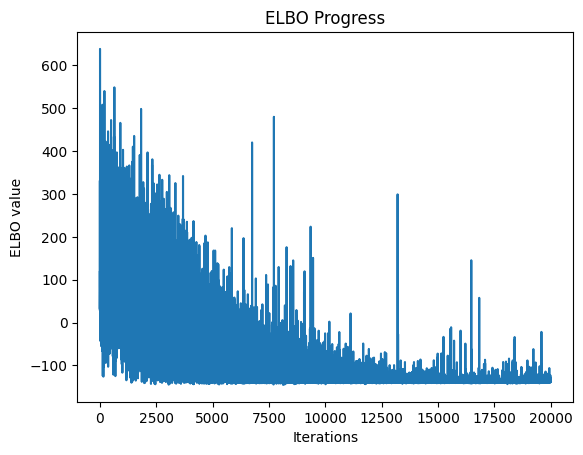

In [38]:
plt.plot(trace_aprox_2.hist)
plt.title('ELBO Progress')
plt.xlabel('Iterations')
plt.ylabel('ELBO value')
plt.show()

In [39]:
pm.summary(trace_2)

Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
l_ratquad,3.724,4.350,0.227,10.331,0.205,0.145,456.0,496.0,NaN
alpha_ratquad,4.139,3.244,0.499,10.077,0.138,0.101,557.0,460.0,NaN
sigma_ratquad,2.635,3.519,0.104,7.968,0.157,0.113,500.0,514.0,NaN
l_expquad,0.342,0.127,0.137,0.548,0.006,0.004,525.0,424.0,NaN
sigma_expquad,0.126,0.248,0.001,0.433,0.011,0.008,436.0,421.0,NaN
l_matern52,0.764,0.274,0.363,1.369,0.013,0.009,451.0,472.0,NaN
sigma_matern52,0.299,0.395,0.008,0.868,0.018,0.013,500.0,491.0,NaN
sigma,0.095,0.007,0.083,0.108,0.000,0.000,463.0,473.0,NaN


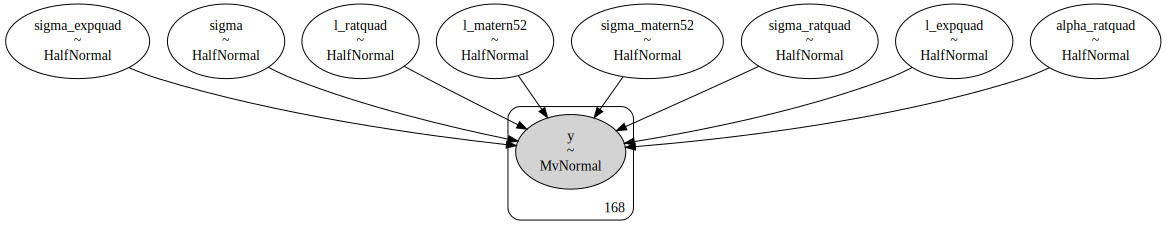

In [40]:
pm.model_to_graphviz(model_2)

In [41]:
with model_2:
    x_teste_c = gp.conditional('x_teste', x_teste.reshape(-1,1))
    pred_m_2 = pm.sample_posterior_predictive(trace_2, var_names=["x_teste"])

<ipython-input-42-7b8cc952de88>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(pred_m_2, group="posterior_predictive", num_samples=200)["x_teste"],


Text(0.5, 1.0, 'Posterior predictive')

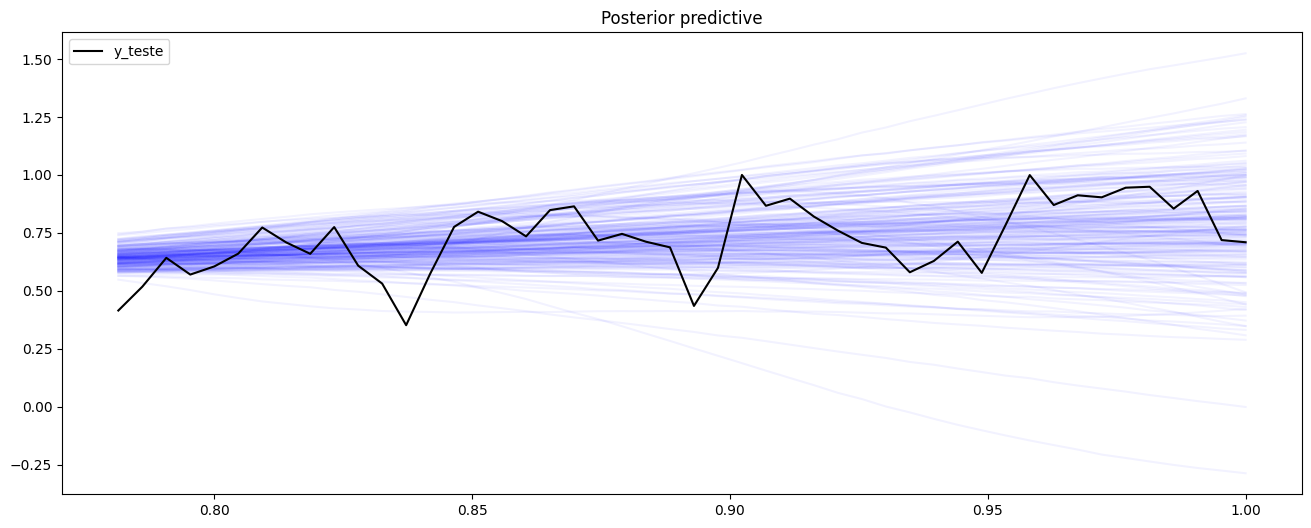

In [42]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(
    x_teste,
    az.extract_dataset(pred_m_2, group="posterior_predictive", num_samples=200)["x_teste"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), color="k", label='y_teste', ax=ax)
ax.set_title("Posterior predictive")

In [43]:
f_pred_samples_2 = az.extract(pred_m_2, group="posterior_predictive", var_names=["x_teste"])
f_pred_samples_2

<xarray.DataArray 'x_teste' (x_teste_dim_2: 48, sample: 500)>
array([[0.66311622, 0.59689189, 0.59907655, ..., 0.62221292, 0.69093351,
        0.64734209],
       [0.666171  , 0.60004123, 0.59821626, ..., 0.62660114, 0.69580425,
        0.651249  ],
       [0.67260095, 0.60022114, 0.5970886 , ..., 0.6305971 , 0.70467697,
        0.65594193],
       ...,
       [0.85253191, 0.5654722 , 0.56597093, ..., 0.6891297 , 1.03973052,
        0.91640284],
       [0.8528465 , 0.56367348, 0.5661333 , ..., 0.69091137, 1.04538221,
        0.92056155],
       [0.85383496, 0.55955843, 0.5639008 , ..., 0.68651633, 1.0498448 ,
        0.92710901]])
Coordinates:
  * x_teste_dim_2  (x_teste_dim_2) int64 0 1 2 3 4 5 6 ... 41 42 43 44 45 46 47
  * sample         (sample) object MultiIndex
  * chain          (sample) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
  * draw           (sample) int64 0 1 2 3 4 5 6 ... 493 494 495 496 497 498 499

<Axes: >

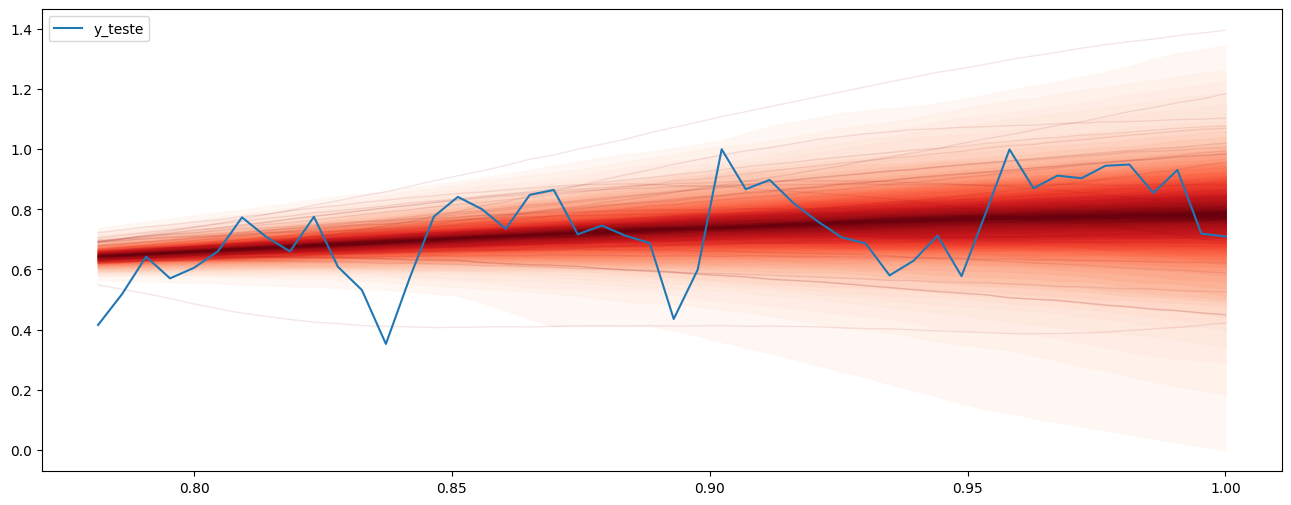

In [44]:
from pymc.gp.util import plot_gp_dist

fig = plt.figure(figsize=(16,6)); ax = fig.gca()

plot_gp_dist(ax, f_pred_samples_2.T, x_teste);

sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), label='y_teste', ax=ax)

In [45]:
y_pred_2 = pred_m_2.posterior_predictive["x_teste"].values.mean(axis=1)[0]
print(f"MAE: {abs(y_pred_2 - y_teste).sum()/len(y_teste)}")

MAE: 0.10946570244828506


# Modelo 3

usando uma função de covariância com  cosine kernel

In [60]:
with pm.Model() as model_3:

    l_ratquad = pm.HalfNormal('l_ratquad', sigma=4)
    alpha_ratquad = pm.HalfNormal('alpha_ratquad', sigma=4)
    sigma_ratquad = pm.HalfNormal('sigma_ratquad', sigma=4)

    l_cosine = pm.HalfNormal('l_cosine', sigma=0.1)
    sigma_cosine = pm.HalfNormal('sigma_cosine', sigma=0.1)

    cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)
    cov_cosine = sigma_cosine * pm.gp.cov.Cosine(1, l_cosine)

    cov = cov_ratquad + cov_cosine

    a = pm.Normal("a",0,1)
    b = pm.Normal("b",0,0.125)
    trend = pm.Deterministic("trend",a + b*x_treino)
    M = pm.gp.mean.Linear([b],a)

    gp = pm.gp.Marginal(mean_func=M, cov_func=cov)
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = gp.marginal_likelihood('y', X=x_treino.reshape(-1,1),y=y_treino, noise=sigma)


/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


## Preditiva a priori

Para ajustar os parâmetros

In [61]:
with model_3:
  prior_3 = pm.sample_prior_predictive()

In [62]:
prior_3

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

<ipython-input-63-b9188df45198>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior_3, group="prior_predictive", num_samples=100)["y"]
<ipython-input-63-b9188df45198>:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior_3, group="prior", num_samples=100)["trend"] * y_treino.max(),


Text(0.5, 1.0, 'Prior trend lines')

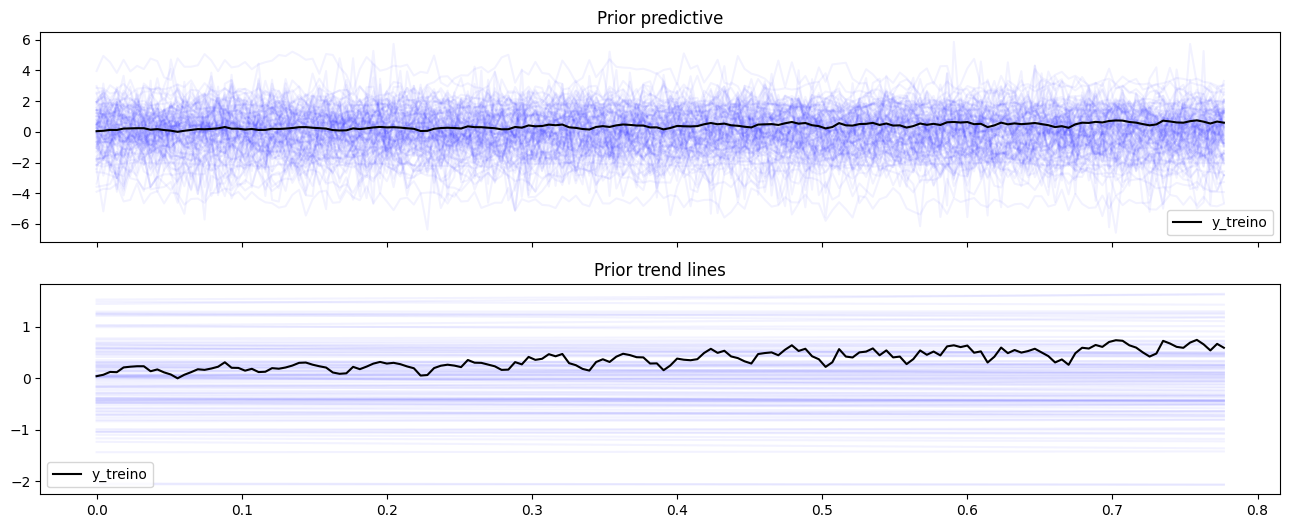

In [63]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16,6))
ax[0].plot(
    x_treino,
    az.extract_dataset(prior_3, group="prior_predictive", num_samples=100)["y"]
    * y_treino.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), color="k", label='y_treino', ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    x_treino,
    az.extract_dataset(prior_3, group="prior", num_samples=100)["trend"] * y_treino.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), color="k",label='y_treino', ax=ax[1])
ax[1].set_title("Prior trend lines")

In [64]:
with model_3:
  trace_aprox_3 = pm.fit(20000)
  trace_3 = trace_aprox_3.sample()

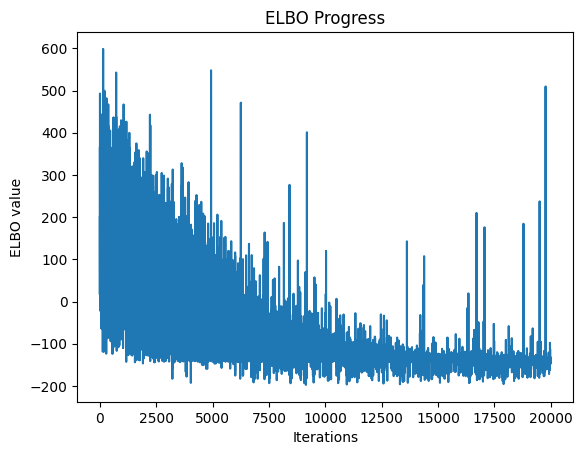

In [65]:
plt.plot(trace_aprox_3.hist)
plt.title('ELBO Progress')
plt.xlabel('Iterations')
plt.ylabel('ELBO value')
plt.show()

In [66]:
pm.summary(trace_3)

Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.108,0.923,-1.767,1.629,0.043,0.030,458.0,463.0,NaN
b,0.056,0.132,-0.167,0.311,0.006,0.004,431.0,401.0,NaN
l_ratquad,3.798,3.654,0.263,9.892,0.175,0.124,454.0,406.0,NaN
alpha_ratquad,3.581,1.643,1.136,6.657,0.072,0.051,504.0,474.0,NaN
sigma_ratquad,3.748,2.802,0.501,8.409,0.128,0.091,480.0,472.0,NaN
...,...,...,...,...,...,...,...,...,...
trend[163],0.151,0.922,-1.877,1.544,0.043,0.030,457.0,401.0,NaN
trend[164],0.151,0.922,-1.876,1.545,0.043,0.030,456.0,401.0,NaN
trend[165],0.151,0.922,-1.875,1.546,0.043,0.030,456.0,401.0,NaN
trend[166],0.151,0.922,-1.874,1.546,0.043,0.030,456.0,401.0,NaN


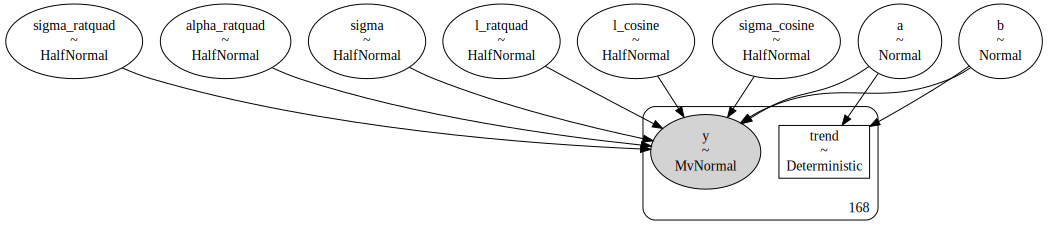

In [67]:
pm.model_to_graphviz(model_3)

In [68]:
with model_3:
    x_teste_c = gp.conditional('x_teste', x_teste.reshape(-1,1))
    pred_m_3 = pm.sample_posterior_predictive(trace_3, var_names=["x_teste"])

In [69]:
pred_m_3

Inference data with groups:
	> posterior_predictive
	> observed_data

<ipython-input-70-3419f8e8be96>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(pred_m_3, group="posterior_predictive", num_samples=200)["x_teste"],


Text(0.5, 1.0, 'Posterior predictive')

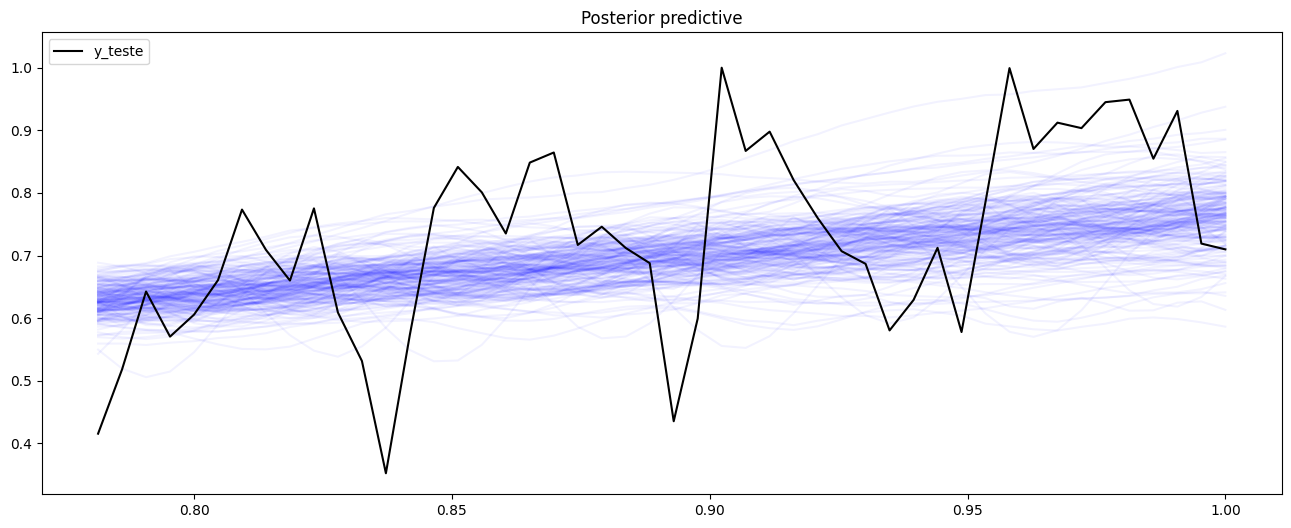

In [70]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(
    x_teste,
    az.extract_dataset(pred_m_3, group="posterior_predictive", num_samples=200)["x_teste"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), color="k", label='y_teste', ax=ax)
ax.set_title("Posterior predictive")

In [71]:
f_pred_samples_3 = az.extract(pred_m_3, group="posterior_predictive", var_names=["x_teste"])
f_pred_samples_3

<xarray.DataArray 'x_teste' (x_teste_dim_2: 48, sample: 500)>
array([[0.64493811, 0.59980156, 0.62138045, ..., 0.62432154, 0.51205188,
        0.63679444],
       [0.64680355, 0.59472909, 0.62465268, ..., 0.62930337, 0.54779989,
        0.62925348],
       [0.64820102, 0.5955026 , 0.62918642, ..., 0.6315851 , 0.60387608,
        0.6236012 ],
       ...,
       [0.76891027, 0.68478907, 0.71768717, ..., 0.72611119, 0.63750933,
        0.74558589],
       [0.77293573, 0.6838437 , 0.71862729, ..., 0.73041299, 0.6095088 ,
        0.74207016],
       [0.77539708, 0.68424629, 0.72008779, ..., 0.72965783, 0.60553328,
        0.74587409]])
Coordinates:
  * x_teste_dim_2  (x_teste_dim_2) int64 0 1 2 3 4 5 6 ... 41 42 43 44 45 46 47
  * sample         (sample) object MultiIndex
  * chain          (sample) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
  * draw           (sample) int64 0 1 2 3 4 5 6 ... 493 494 495 496 497 498 499

<Axes: >

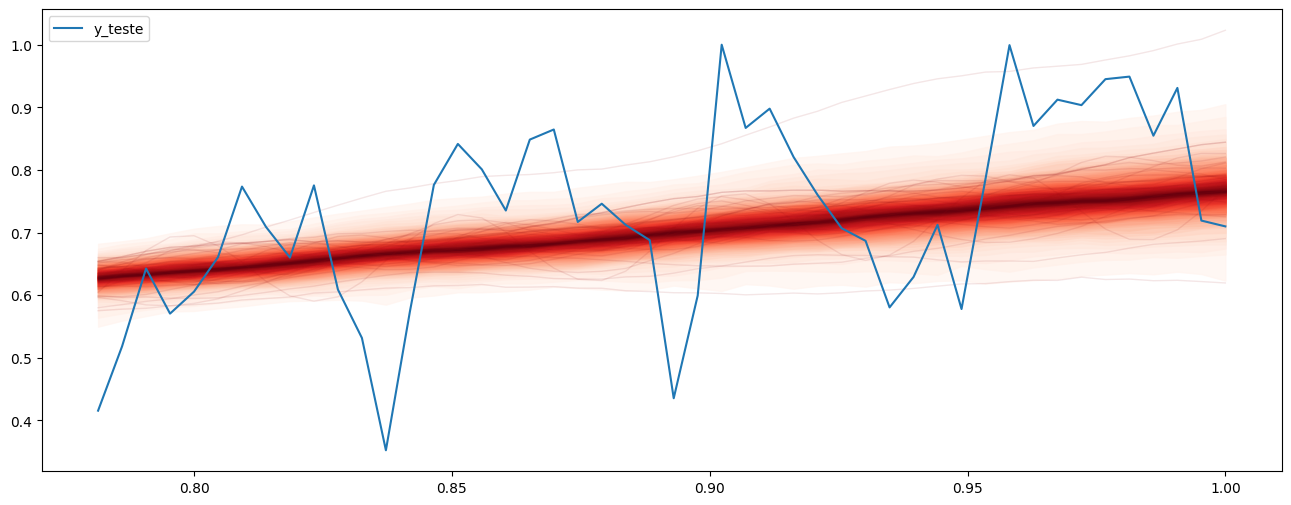

In [72]:
from pymc.gp.util import plot_gp_dist

fig = plt.figure(figsize=(16,6)); ax = fig.gca()

plot_gp_dist(ax, f_pred_samples_3.T, x_teste);

sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), label='y_teste', ax=ax)

In [73]:
y_pred_3 = pred_m_3.posterior_predictive["x_teste"].values.mean(axis=1)[0]
print(f"MAE: {abs(y_pred_3 - y_teste).sum()/len(y_teste)}")

MAE: 0.11241986066887444
